In [5]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers
from keras.utils import to_categorical


In [6]:
# Load the data into a pandas DataFrame
print(os.getcwd())
df = pd.read_csv(
    filepath_or_buffer=os.getcwd()+'/../../data/monks/monks-1.train',
    names=['target', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'id'],
    delimiter=' '
)

# Display the loaded data
df

/Users/gianlucapanzani/Documents/GitHub/Machine_Learning_Project/frameworks/tfkeras


,target,col1,col2,col3,col4,col5,col6,id
NaN,1,1,1,1,1,3,1,data_5
NaN,1,1,1,1,1,3,2,data_6
NaN,1,1,1,1,3,2,1,data_19
NaN,1,1,1,1,3,3,2,data_22
NaN,1,1,1,2,1,2,1,data_27
...,...,...,...,...,...,...,...,...
NaN,1,3,3,2,1,4,2,data_416
NaN,1,3,3,2,3,1,2,data_426
NaN,1,3,3,2,3,2,2,data_428
NaN,1,3,3,2,3,3,2,data_430


In [7]:
# Initializing labels/targets vector
y = df['target'].values.astype(float)

# Drop of the IDs and the targets
df = df.drop(columns=['target','id'], axis=1)

# Initializing the one-hot DataFrame
df_copy = df.copy(deep=True)

# Iteration on the columns of the DataFrame
for column in df.columns:

    # Creation of the one-hot encoding's columns
    df_one_hot = pd.get_dummies(df[column], dtype=float)

    # Change the name of the columns
    df_one_hot = df_one_hot.set_axis([column+'_'+str(col) for col in df_one_hot.columns], axis=1)

    # Drop of the initial column
    df_copy.drop(labels=column, axis=1, inplace=True)

    # Concatenation of the new columns to the DataFrame
    df_copy = pd.concat([df_copy,df_one_hot], axis=1)

# Print of the obtained DataFrame   col1_2	col1_3	 col2_2	col2_3  col3_2	col3_3  col4_2	col4_3	col5_2	col5_3 col6_2		
df_copy

,col1_1,col1_2,col1_3,col2_1,col2_2,col2_3,col3_1,col3_2,col4_1,col4_2,col4_3,col5_1,col5_2,col5_3,col5_4,col6_1,col6_2
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


# Model Selection

## K-fold Cross Validation 

In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import EarlyStopping

!pip install keras_tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

# Parameters' space for Grid Search
param_space = {
    'input_units': [17],
    'units': [2, 3, 4],
    'optimizer': ['sgd'],
    'learning_rate': [0.001, 0.002, 0.003, 0.1, 0.2, 0.3],
    'batch_size': [15, 31, 62, 124],
    'epochs': [390],
    'weight_decay': [0.1, 0.01, 0.001, 0.0001],
    'momentum': [0.5, 0.6],
    'activation': ['tanh', 'relu'],
    'metrics': ['accuracy']
}

# Assigning new DataFrame to Data set variable
X = df_copy.values

# Number of trials with random combinations
num_trials = 10

# K-fold Cross-validation
k = 5
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store training and validation accuracies
training_accuracies = []
validation_accuracies = []

# Lists to store best hyperparameters
best_hyperparameters = {
    'trial': 0,
    'params': {},
    'mean_validation_accuracy': 0
}

# Lists to store fold-wise accuracies
fold_training_accuracies = []
fold_validation_accuracies = []

# For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
for train_index, val_index in kfold.split(X, y):
    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Inizializza il tuner (Random Search) per ogni fold
    tuner = RandomSearch(
        build_model,  # Funzione del modello
        objective='val_accuracy',  # Obiettivo da massimizzare
        max_trials=5,  # Numero totale di tentativi di iperparametri
        directory='my_dir',  # Directory per salvare i risultati
        project_name=f'helloworld_fold_{fold}'# Nome del progetto per ogni fold
    )

    # Esegui la ricerca degli iperparametri
    tuner.search(x=x_train_fold, y=y_train_fold, epochs=5, validation_data=(x_val_fold, y_val_fold))

    # Estrai il miglior modello per ogni fold
    best_model = tuner.get_best_models(num_models=1)[0]
    
    # Addestra il miglior modello sul training set completo
    best_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

    # Sets the Loss Function, the Optimizer used in the model, and the Metrics used for evaluation
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[params['metrics']])

    # Set the Early Stopping for the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Training of the model with validation split and early stopping
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],  # Add early stopping callback
        verbose=0
    )

    # Evaluate on both training and validation sets
    training_accuracy = model.evaluate(X_train, y_train, verbose=0)[1]
    validation_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]

    fold_training_accuracies.append(training_accuracy)
    fold_validation_accuracies.append(validation_accuracy)

    # Calculate mean accuracies across folds for this trial
    mean_training_accuracy = np.mean(fold_training_accuracies)
    mean_validation_accuracy = np.mean(fold_validation_accuracies)

    # Store mean accuracies for this trial
    training_accuracies.append(mean_training_accuracy)
    validation_accuracies.append(mean_validation_accuracy)

    # Print mean accuracies and hyperparameters for this trial
    print(f"Trial {i+1}: Mean Training Accuracy={mean_training_accuracy:.4f}, Mean Validation Accuracy={mean_validation_accuracy:.4f}")
    print("Hyperparameters:", params)

    # Update best hyperparameters if current trial has higher validation accuracy
    if mean_validation_accuracy > best_hyperparameters['mean_validation_accuracy']:
        best_hyperparameters['trial'] = i + 1
        best_hyperparameters['params'] = params
        best_hyperparameters['mean_validation_accuracy'] = mean_validation_accuracy

# Print overall mean accuracies
print(f"\nOverall Mean Training Accuracy: {np.mean(training_accuracies):.4f}")
print(f"Overall Mean Validation Accuracy: {np.mean(validation_accuracies):.4f}")

# Print best hyperparameters
print("\nBest Hyperparameters:")
print("Trial:", best_hyperparameters['trial'])
print("Hyperparameters:", best_hyperparameters['params'])
print("Mean Validation Accuracy:", best_hyperparameters['mean_validation_accuracy'])


NameError: name 'build_model' is not defined

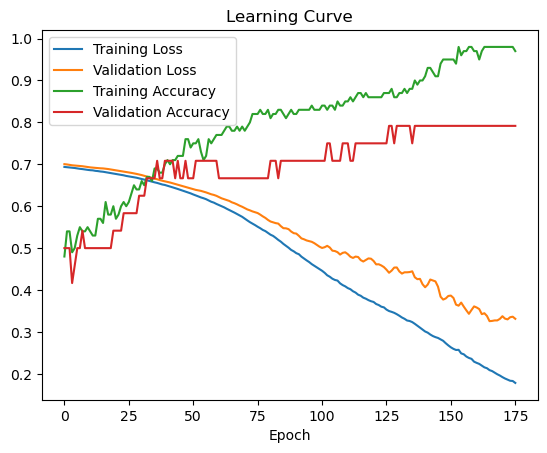

In [ ]:
# Plot the learning curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.legend()
